# Exploratory Data Analysis - Data preparation for the ML

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
train_df = pd.read_csv('../input/kepler-labelled-time-series-data/exoTrain.csv')

[Text(0.5, 1.0, 'Null values')]

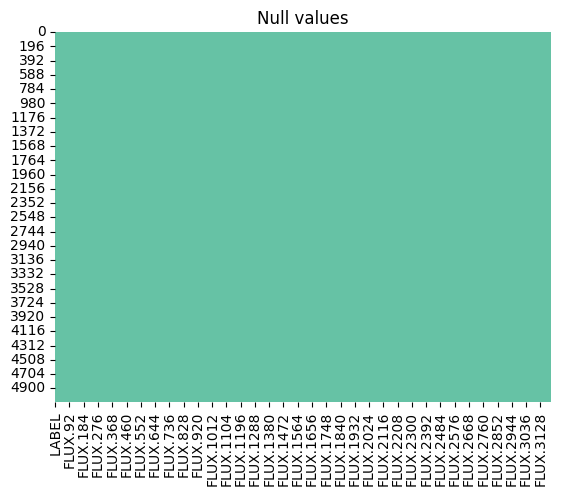

In [3]:
train_df[train_df.isnull().any(axis = 1)]
sns.heatmap(train_df.isnull(), cmap = 'Set2', cbar = False).set(title='Null values')

LABEL
0    5050
1      37
Name: count, dtype: int64


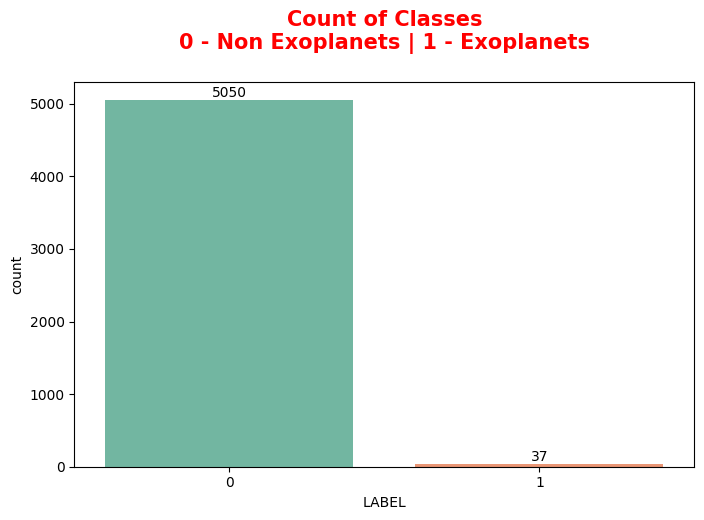

In [4]:
# Changing the labels, 0 for non exoplanetary stars and 1 for exoplanetary
train_df = train_df.replace({'LABEL' : {1:0, 2:1}})
print(train_df['LABEL'].value_counts())

plt.figure(figsize=(8, 5))

# Create a count plot for the 'LABEL' column with a different color palette
ax = sns.countplot(x='LABEL', data=train_df, palette='Set2')

# Add labels to each bar in the count plot
for container in ax.containers:
    ax.bar_label(container)

# Set the title of the plot with specified font size, color, weight, and location
plt.title("Count of Classes\n0 - Non Exoplanets | 1 - Exoplanets\n", 
          fontsize=15, color='red', weight='bold', loc="center")

plt.show()

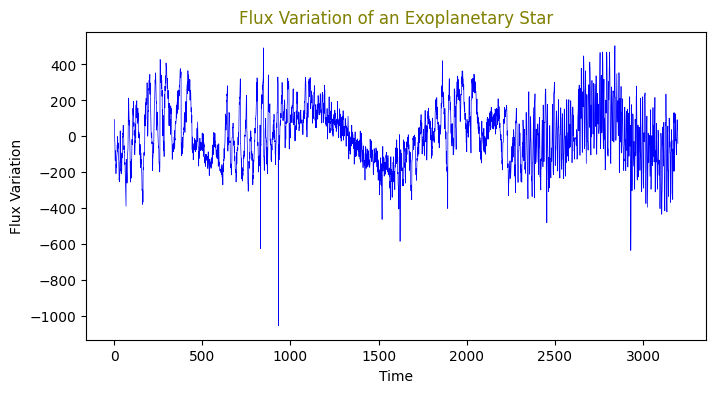

In [5]:
# Drop the 'LABEL' column to plot only the flux values
plot_df = train_df.drop(['LABEL'], axis=1)

# Extract X-axis data: Replace "FLUX." from each column name to get time values
col_names = list(plot_df.columns)
time = [int(col_name.replace("FLUX.", "")) for col_name in col_names]

# Function to plot the flux variation of a star
def flux_plot(df, candidate, exo=True):
    # Determine the color based on whether the star has an exoplanet
    color = 'b' if exo else 'm'
    
    # Set up the plot with specified size
    plt.figure(figsize=(8, 4))
    
    # Plot the flux variation for the selected candidate
    plt.plot(time, df.iloc[candidate - 1], linewidth=0.5, color=color)
    
    # Define titles and colors for the plot based on the presence of exoplanets
    title1, clr1 = "Flux Variation of an Exoplanetary Star", 'olive'
    title2, clr2 = f"Flux Variation of Star {candidate} without Exoplanets", 'tab:red'
    
    # Set the plot title
    plt.title(title1, color=clr1) if exo else plt.title(title2, color=clr2)
    
    # Label the X and Y axes
    plt.xlabel("Time")
    plt.ylabel("Flux Variation")

# Usage
flux_plot(plot_df, candidate=1, exo=True)

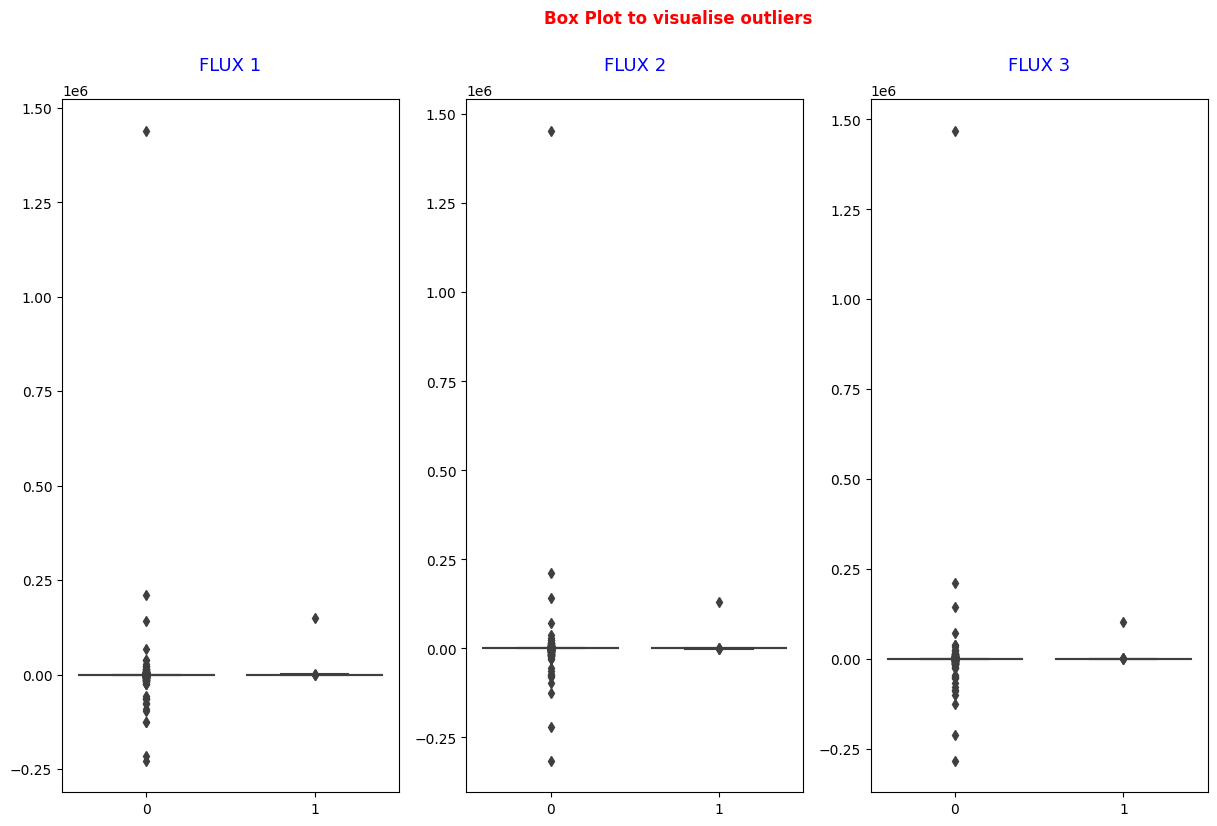

In [6]:
# Boxplot to visualise outliers
plt.figure(figsize = (20, 9))
plt.suptitle("Box Plot to visualise outliers", ha = 'right', color = 'red', weight = 'bold')
for i in range(1, 4):
    plt.subplot(1, 4, i)
    sns.boxplot(data=train_df, x='LABEL', y = 'FLUX.' + str(i))
    plt.xlabel("")
    plt.ylabel("")
    plt.title("FLUX " + str(i) + "\n", color = 'b', fontsize = 13)

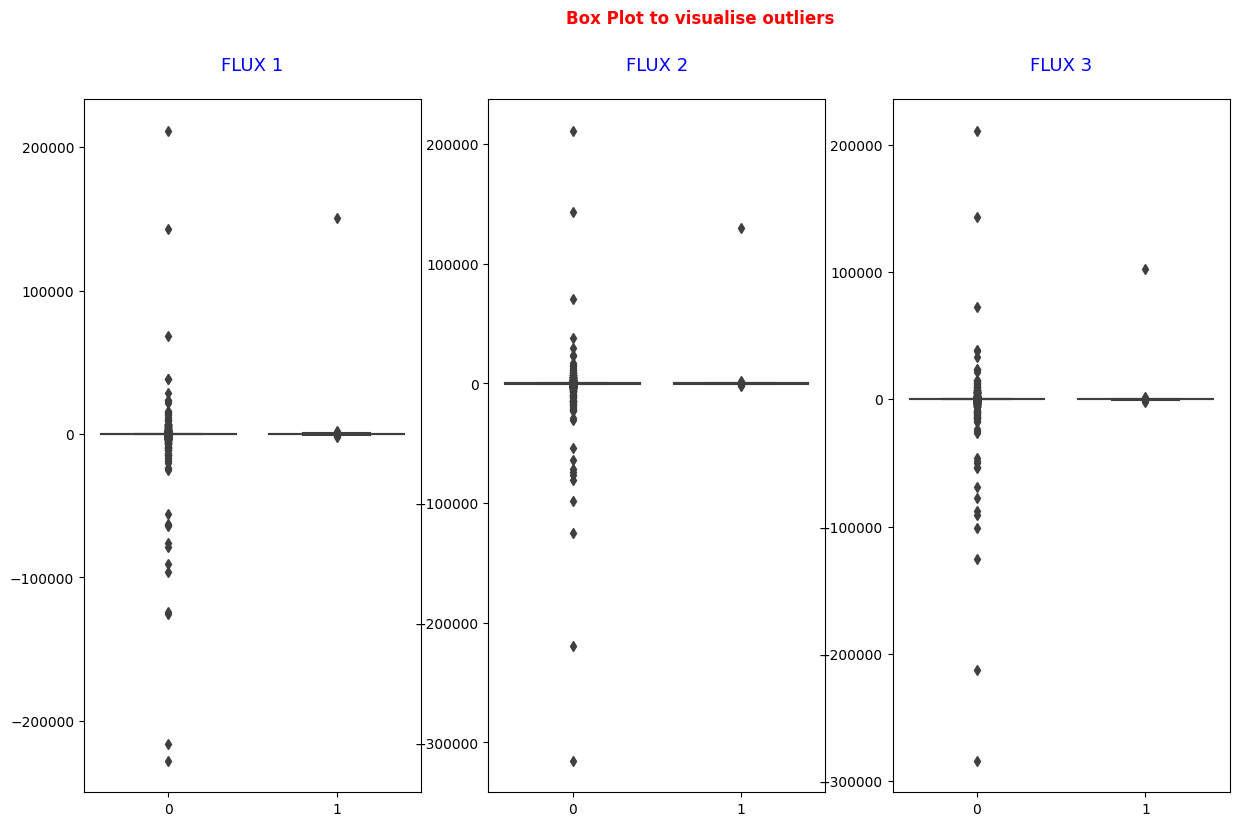

In [7]:
# Removing Outliers
extreme_outliers = train_df[train_df['FLUX.2'] > 0.25e6]
train_df.drop(extreme_outliers.index, axis = 0, inplace = True)

# Same boxplot to visualise the change
plt.figure(figsize = (20, 9))
plt.suptitle("Box Plot to visualise outliers", ha = 'right', color = 'red', weight = 'bold')
for i in range(1, 4):
    plt.subplot(1, 4, i)
    sns.boxplot(data=train_df, x='LABEL', y = 'FLUX.' + str(i))
    plt.xlabel("")
    plt.ylabel("")
    plt.title("FLUX " + str(i) + "\n", color = 'b', fontsize = 13)

In [8]:
# Extract dependent and independent features
x = train_df.drop(['LABEL'], axis = 1)
y = train_df.LABEL

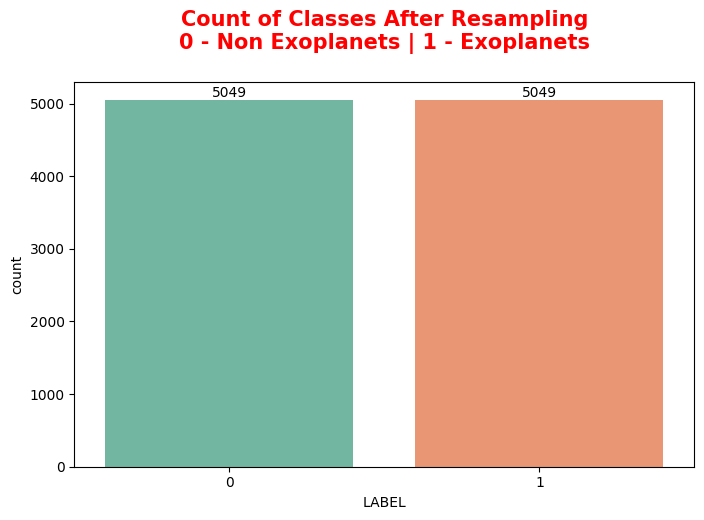

In [9]:
# Apply Random Over Sampling
ros = RandomOverSampler()
x_ros, y_ros = ros.fit_resample(x, y) 

# Combine x_ros and y_ros into a single DataFrame for plotting
ros_df = pd.concat([pd.DataFrame(x_ros, columns=x.columns), pd.Series(y_ros, name='LABEL')], axis=1)

# Create a count plot for the 'LABEL' column with the resampled data
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='LABEL', data=ros_df, palette='Set2')

# Add labels to each bar in the count plot
for container in ax.containers:
    ax.bar_label(container)

# Set the title of the plot with specified font size, color, weight, and location
plt.title("Count of Classes After Resampling\n0 - Non Exoplanets | 1 - Exoplanets\n", 
          fontsize=15, color='red', weight='bold', loc='center')

# Display the plot
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x_ros, y_ros, test_size = 0.3, random_state = 0)

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# Machine Learning Algorithms

## K-Nearest Neighbors

Finding the optimal value of K between 1 and 20...



Completed! Here is the error rate variation with respect to K values:



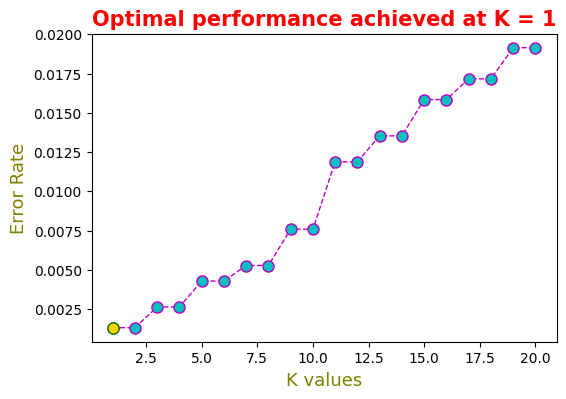

In [11]:
from sklearn.metrics import log_loss, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier as KNC

def optimal_Kval_KNN(start_k, end_k, x_train, x_test, y_train, y_test, display_progress=True):
    # Print the header message
    print(f"Finding the optimal value of K between {start_k} and {end_k}...\n\n")

    # List to store mean error rates for each K
    mean_errors = []
    
    # Iterate through the range of K values
    for K in range(start_k, end_k + 1):
        # Initialize and fit the KNN model with the current K value
        knn = KNC(n_neighbors=K)
        knn.fit(x_train, y_train)
        
        # Calculate the mean error rate
        error_rate = np.mean(knn.predict(x_test) != y_test)
        mean_errors.append(error_rate)
        
        # Print the error rate if display_progress is True
        if display_progress:
            print(f'For K = {K}, mean error = {error_rate:.3f}')
    
    # Determine the optimal K value and its corresponding error rate
    optimal_k = mean_errors.index(min(mean_errors)) + 1
    optimal_error = min(mean_errors)
    
    # Print completion message
    print('\nCompleted! Here is the error rate variation with respect to K values:\n')
    
    # Plot the error rate versus K values and highlight the optimal K value
    plt.figure(figsize=(6, 4))
    plt.plot(range(start_k, end_k + 1), mean_errors, 'mo--', markersize=8, markerfacecolor='c', linewidth=1)
    plt.plot(optimal_k, optimal_error, marker='o', markersize=8, markerfacecolor='gold', markeredgecolor='g')
    plt.title(f"Optimal performance achieved at K = {optimal_k}", color='r', weight='bold', fontsize=15)
    plt.ylabel("Error Rate", color='olive', fontsize=13)
    plt.xlabel("K values", color='olive', fontsize=13)
    
    # Return the optimal K value
    return optimal_k

k = optimal_Kval_KNN(1, 20, X_train_sc, X_test_sc, y_train, y_test, display_progress=False)

In [12]:
# Initialize the KNN Classifier with K = 1
knn_classifier = KNC(n_neighbors=1, metric='minkowski', p=2)

knn_classifier.fit(X_train_sc, y_train)

# Make predictions on the scaled test data
y_pred = knn_classifier.predict(X_test_sc)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_sc.shape[0], (y_test != y_pred).sum()))

# Calculate the test accuracy and convert it to percentage
test_accuracy = accuracy_score(y_test, y_pred) * 100
print(f'\nTest accuracy of KNN is {test_accuracy:.2f}%')

# Calculate the log loss
test_loss = log_loss(y_test, y_pred)
print(f'\nTest loss of KNN is {test_loss:.5f}')

# Calculate the F1 score and convert it to percentage
test_f1_score = f1_score(y_test, y_pred) * 100
print(f'\nF1 score of KNN is {test_f1_score:.2f}%')

Number of mislabeled points out of a total 3030 points : 4

Test accuracy of KNN is 99.87%

Test loss of KNN is 0.04758

F1 score of KNN is 99.87%


## Gaussian Naive Bayes

In [13]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train_sc, y_train).predict(X_test_sc)

# Calculating measurements
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_sc.shape[0], (y_test != y_pred).sum()))

test_accuracy = accuracy_score(y_test, y_pred) * 100
print(f'\nTest accuracy of GNB is {test_accuracy:.2f}%')

test_loss = log_loss(y_test, y_pred)
print(f'\nTest loss of GNB is {test_loss:.2f}')

test_f1_score = f1_score(y_test, y_pred) * 100
print(f'\nF1 score of GNB is {test_f1_score:.2f}%')

Number of mislabeled points out of a total 3030 points : 1514

Test accuracy of KNN is 50.03%

Test loss of KNN is 18.01

F1 score of KNN is 66.01%


## Bernoulli Naive Bayes

In [14]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
y_pred = bnb.fit(X_train_sc, y_train).predict(X_test_sc)

# Calculating measurements
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_sc.shape[0], (y_test != y_pred).sum()))

test_accuracy = accuracy_score(y_test, y_pred) * 100
print(f'\nTest accuracy of BNB is {test_accuracy:.2f}%')

test_loss = log_loss(y_test, y_pred)
print(f'\nTest loss of BNB is {test_loss:.2f}')

test_f1_score = f1_score(y_test, y_pred) * 100
print(f'\nF1 score of BNB is {test_f1_score:.2f}%')

Number of mislabeled points out of a total 3030 points : 1138

Test accuracy of KNN is 62.44%

Test loss of KNN is 13.54

F1 score of KNN is 51.57%


## Random Forest

Finding the optimal value of N between 1 and 4...




2

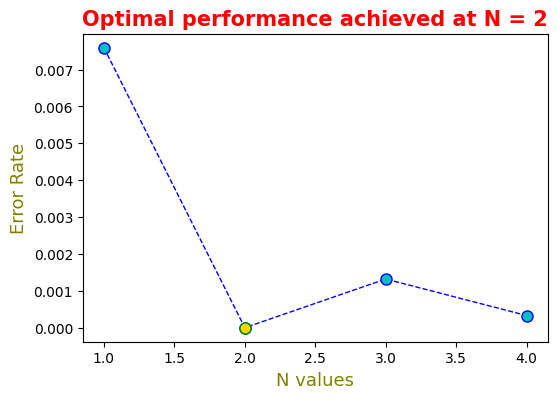

In [15]:
from sklearn.ensemble import RandomForestClassifier

def optimal_est_RF(start_n, end_n, x_train, x_test, y_train, y_test, progress=True):
    # Print header message
    print(f"Finding the optimal value of N between {start_n} and {end_n}...\n\n")

    # List to store mean error rates for each N
    mean_errors = []
    
    # Iterate through the range of N values
    for N in range(start_n, end_n + 1):
        # Initialize Random Forest classifier with current N value
        clf = RandomForestClassifier(n_estimators=N)
        clf.fit(x_train, y_train)
        
        # Calculate mean error rate
        error_rate = np.mean(clf.predict(x_test) != y_test)
        mean_errors.append(error_rate)
        
        # Print error rate if progress is True
        if progress:
            print(f'For N = {N}, mean error = {error_rate:.3f}')
    
    # Determine optimal N value and corresponding error rate
    optimal_n = mean_errors.index(min(mean_errors)) + 1
    optimal_error = min(mean_errors)
    
    # Plot error rate versus N values and highlight optimal N value
    plt.figure(figsize=(6, 4))
    plt.plot(range(start_n, end_n + 1), mean_errors, 'bo--', markersize=8, markerfacecolor='c', linewidth=1)
    plt.plot(optimal_n, optimal_error, marker='o', markersize=8, markerfacecolor='gold', markeredgecolor='g')
    plt.title(f"Optimal performance achieved at N = {optimal_n}", color='r', weight='bold', fontsize=15)
    plt.ylabel("Error Rate", color='olive', fontsize=13)
    plt.xlabel("N values", color='olive', fontsize=13)
    
    # Return optimal N value
    return optimal_n

optimal_est_RF(1, 4, X_train_sc, X_test_sc, y_train, y_test, progress=False)

In [16]:
rfc = RandomForestClassifier(n_estimators=2)
y_pred = rfc.fit(X_train_sc, y_train).predict(X_test_sc)

# Calculating measurements
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_sc.shape[0], (y_test != y_pred).sum()))

test_accuracy = accuracy_score(y_test, y_pred) * 100
print(f'\nTest accuracy of RFC is {test_accuracy:.2f}%')

test_loss = log_loss(y_test, y_pred)
print(f'\nTest loss of RFC is {test_loss:.4f}')

test_f1_score = f1_score(y_test, y_pred) * 100
print(f'\nF1 score of RFC is {test_f1_score:.2f}%')

Number of mislabeled points out of a total 3030 points : 0

Test accuracy of KNN is 100.00%

Test loss of KNN is 0.0000

F1 score of KNN is 100.00%


## Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression(random_state=0, max_iter=1000)
y_pred = lrc.fit(X_train_sc, y_train).predict(X_test_sc)

# Calculating measurements
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_sc.shape[0], (y_test != y_pred).sum()))

test_accuracy = accuracy_score(y_test, y_pred) * 100
print(f'\nTest accuracy of LRC is {test_accuracy:.2f}%')

test_loss = log_loss(y_test, y_pred)
print(f'\nTest loss of LRC is {test_loss:.3f}')

test_f1_score = f1_score(y_test, y_pred) * 100
print(f'\nF1 score of LRC is {test_f1_score:.2f}%')

Number of mislabeled points out of a total 3030 points : 292

Test accuracy of KNN is 90.36%

Test loss of KNN is 3.474

F1 score of KNN is 89.78%


## Support vector machine

In [18]:
from sklearn import svm

svmc = svm.SVC()
y_pred = svmc.fit(X_train_sc, y_train).predict(X_test_sc)

# Calculating measurements
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_sc.shape[0], (y_test != y_pred).sum()))

test_accuracy = accuracy_score(y_test, y_pred) * 100
print(f'\nTest accuracy of SVM is {test_accuracy:.2f}%')

test_loss = log_loss(y_test, y_pred)
print(f'\nTest loss of SVM is {test_loss:.5f}')

test_f1_score = f1_score(y_test, y_pred) * 100
print(f'\nF1 score of SVM is {test_f1_score:.2f}%')

Number of mislabeled points out of a total 3030 points : 1323

Test accuracy of KNN is 56.34%

Test loss of KNN is 15.73787

F1 score of KNN is 23.57%


## Gradient Boosting Classifier

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
    max_depth=1, random_state=0)

# Calculating measurements
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test_sc.shape[0], (y_test != y_pred).sum()))

test_accuracy = accuracy_score(y_test, y_pred) * 100
print(f'\nTest accuracy of GBC is {test_accuracy:.2f}%')

test_loss = log_loss(y_test, y_pred)
print(f'\nTest loss of GBC is {test_loss:.3f}')

test_f1_score = f1_score(y_test, y_pred) * 100
print(f'\nF1 score of GBC is {test_f1_score:.2f}%')

Number of mislabeled points out of a total 3030 points : 1323

Test accuracy of KNN is 56.34%

Test loss of KNN is 15.738

F1 score of KNN is 23.57%
